This notebook will showcase machine learning methods that can be used to predict the budget for the year 2024, using the sales data from 2022 - 2023. 

In [28]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

## Revenue Forecasting using SARIMA

### Loading the datasets

In [6]:
sales_df = pd.read_csv("FACT_InternetSales_final.csv")

In [7]:
sales_df.head()

,ProductKey,OrderDateKey,CustomerKey,SalesOrderNumber,SalesAmount
0,310,20201229,21768,SO43697,3578.2700
1,346,20201229,28389,SO43698,3399.9900
2,346,20201229,25863,SO43699,3399.9900
3,336,20201229,14501,SO43700,699.0982
4,346,20201229,11003,SO43701,3399.9900


In [8]:
if 'OrderDateKey' in sales_df.columns and not pd.api.types.is_datetime64_any_dtype(sales_df['OrderDateKey']):
    sales_df['OrderDateKey'] = pd.to_datetime(sales_df['OrderDateKey'], format='%Y%m%d')
    sales_df['Month'] = sales_df['OrderDateKey'].dt.to_period('M')


In [9]:
sales_df.head()

,ProductKey,OrderDateKey,CustomerKey,SalesOrderNumber,SalesAmount,Month
0,310,2020-12-29,21768,SO43697,3578.2700,2020-12
1,346,2020-12-29,28389,SO43698,3399.9900,2020-12
2,346,2020-12-29,25863,SO43699,3399.9900,2020-12
3,336,2020-12-29,14501,SO43700,699.0982,2020-12
4,346,2020-12-29,11003,SO43701,3399.9900,2020-12


In [10]:
sales_df.dtypes

ProductKey                   int64
OrderDateKey        datetime64[ns]
CustomerKey                  int64
SalesOrderNumber            object
SalesAmount                float64
Month                    period[M]
dtype: object

In [11]:
# Aggregate monthly sales using pd.Grouper
monthly_sales = sales_df.groupby(
    pd.Grouper(key='OrderDateKey', freq='M')
)['SalesAmount'].sum().reset_index()

# Extract Year and Month from the aggregated data
monthly_sales['Year'] = monthly_sales['OrderDateKey'].dt.year
monthly_sales['Month'] = monthly_sales['OrderDateKey'].dt.month

# Drop the original DateKey column if no longer needed
monthly_sales = monthly_sales[['Year', 'Month', 'SalesAmount']]

In [12]:
#dropping the january 2024 entry as the data is incomplete
monthly_sales = monthly_sales.drop(index=0)
monthly_sales = monthly_sales.drop(index=37)

monthly_sales.reset_index(drop=True, inplace=True)

In [14]:
#separate table for monthly sales
monthly_sales['Date'] = pd.to_datetime(monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str) + '-01')
monthly_sales.set_index('Date', inplace=True)

In [15]:
monthly_sales.head()

,Year,Month,SalesAmount
Date,,,
2021-01-01,2021,1,469823.9148
2021-02-01,2021,2,466334.9030
2021-03-01,2021,3,485198.6594
2021-04-01,2021,4,502073.8458
2021-05-01,2021,5,561681.4758


In [16]:
#monthly_sales.to_csv('./data/monthly_sales.csv', index=False)

## SARIMA

In [21]:
ms_df.head()

,Year,Month,SalesAmount
0,2021,1,469823.9148
1,2021,2,466334.9030
2,2021,3,485198.6594
3,2021,4,502073.8458
4,2021,5,561681.4758


In [27]:
# Fit SARIMA model
model = SARIMAX(monthly_sales['SalesAmount'], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 12))
sarima_result = model.fit()

# Forecast for 12 months
forecast = sarima_result.forecast(steps=12)
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        SalesAmount   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -303.270
Date:                            Sat, 14 Dec 2024   AIC                            616.541
Time:                                    07:08:17   BIC                            622.218
Sample:                                01-01-2021   HQIC                           617.969
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5813      1.313     -0.443      0.658      -3.154       1.992
ma.L1          0.3854      1.612   

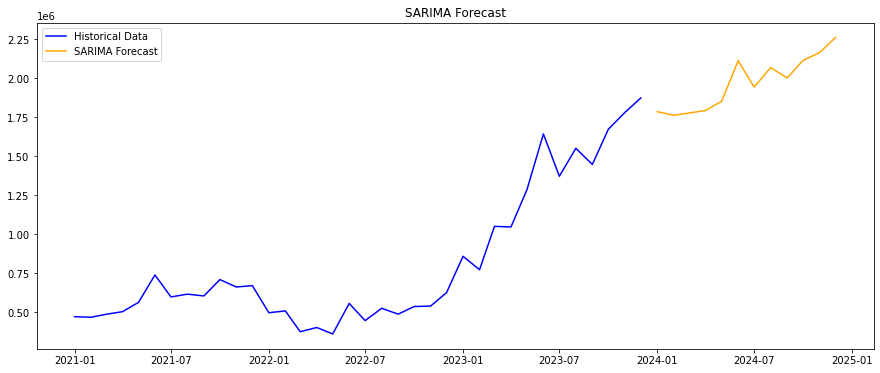

In [25]:
# Plot the forecast
plt.figure(figsize=(15, 6))
plt.plot(monthly_sales.index, monthly_sales['SalesAmount'], label='Historical Data', color='blue')
plt.plot(forecast.index, forecast, label='SARIMA Forecast', color='orange')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

## Year-over-Year Growth Analysis

In [30]:
monthly_sales.head()

,Year,Month,SalesAmount
Date,,,
2021-01-01,2021,1,469823.9148
2021-02-01,2021,2,466334.9030
2021-03-01,2021,3,485198.6594
2021-04-01,2021,4,502073.8458
2021-05-01,2021,5,561681.4758


In [31]:
monthly_sales.tail()

,Year,Month,SalesAmount
Date,,,
2023-08-01,2023,8,1551065.56
2023-09-01,2023,9,1447495.69
2023-10-01,2023,10,1673293.41
2023-11-01,2023,11,1780920.06
2023-12-01,2023,12,1874360.29


In [34]:
forecast

2024-01-01    1.786269e+06
2024-02-01    1.763194e+06
2024-03-01    1.777849e+06
2024-04-01    1.794080e+06
2024-05-01    1.853316e+06
2024-06-01    2.113881e+06
2024-07-01    1.944079e+06
2024-08-01    2.069463e+06
2024-09-01    2.002848e+06
2024-10-01    2.115365e+06
2024-11-01    2.166062e+06
2024-12-01    2.262906e+06
Freq: MS, Name: predicted_mean, dtype: float64

In [35]:
# Sum forecasted 2024 values to get total sales for 2024
forecasted_2024_sales = forecast.sum()

# Calculate yearly revenue, including the forecasted 2024 sales
yearly_sales = monthly_sales.groupby('Year')['SalesAmount'].sum()
yearly_sales.loc[2024] = forecasted_2024_sales  # Add the 2024 forecast

# Calculate Year-over-Year growth rate
yoy_growth = yearly_sales.pct_change() * 100

# Get current year's (2023) growth and forecasted growth for 2024
current_year_growth = yoy_growth.loc[2023]  # Growth from 2022 to 2023
next_year_growth = yoy_growth.loc[2024]     # Forecasted growth from 2023 to 2024

print(f"Current Year Growth (2023): {current_year_growth:.2f}%")
print(f"Forecasted Growth (2024): {next_year_growth:.2f}%")


Current Year Growth (2023): 179.87%
Forecasted Growth (2024): 44.63%
